# Entendimento do Negocio/Dados

<p>O aplicativo ToComFome é um app de entrega de comida por delivery. Como todo aplicativo de varejo, a empresa se preocupa com o Churn de clientes, ou seja, da perda desse cliente para a concorrência. Para entender o perfil de risco do cliente com maior chance de churn, a área de CRM pediu um projeto para a área de Data Analytics para entender e classificar o cliente com risco de trocar de aplicativo nos próximos meses.</p>

<p>Para isso, a área de CRM passou uma amostra de cerca de 10 mil clientes com suas respectivas informações de cadastro e transações nos próximos 4 meses a contar da data de extração usada como referência.</p>

<p>Você foi convidado para atuar neste projeto, e como um(a) bom(a) analista de dados, é importante que você organize e estruture todas as etapas do trabalho. Esse material deverá ser apresentado aos executivos responsáveis pela área demandante em meados de Abril/22.</p>

<p>Com base no desafio da area de negócio, pede-se:</p>

1.    Quais fatores de risco estão associados com o Churn de Clientes?

2.    Segmentar os clientes com a probabilidade de darem Churn nos próximos 4 meses em relação à data de extração de referência.

3.    Quais os possíveis planos de ação que a empresa pode fazer para diminuir esse probl</p>

## 1.0 Importar bibliotecas

In [1]:
import pandas as pd
import scorecardpy as sc
import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns

## 2.0 Leitura da base de dados

In [2]:
df_churn = pd.read_csv('../db_churn.csv')
df_churn = df_churn.drop(columns='ClientId.1')
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26


## 3.0 Descrição dos dados

In [3]:
# Metadados referente ao conjunto de dados
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata


In [4]:
generate_metadata(df_churn)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,ClientId,int64,0,0.0,10000
1,DataExtracao,object,0,0.0,1
2,Score_Credito,int64,0,0.0,460
3,Estado,object,0,0.0,3
4,Gênero,object,0,0.0,2
5,Idade,int64,0,0.0,70
6,Tempo_Cliente,int64,0,0.0,11
7,Limite_Credito_Mercado,float64,0,0.0,6382
8,Qte_Categorias,int64,0,0.0,4
9,Usa_Cartao_Credito,int64,0,0.0,2


In [5]:
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26


In [6]:
## transformando as datas que estao como object para date
df_churn['DataExtracao'] = df_churn['DataExtracao'].astype('datetime64[ns]')
df_churn['DataUltimaTransacao'] = df_churn['DataUltimaTransacao'].astype('datetime64[ns]')


## 3.1 Estatística Descritiva

In [24]:
df_churn.describe().T

,count,mean,min,25%,50%,75%,max,std
ClientId,10000.0,350567.5,345568.0,348067.75,350567.5,353067.25,355567.0,2886.89568
DataExtracao,10000,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,NaN
Score_Credito,10000.0,650.5288,350.0,584.0,652.0,718.0,850.0,96.653299
Idade,10000.0,38.9218,18.0,32.0,37.0,44.0,92.0,10.487806
Tempo_Cliente,10000.0,5.0128,0.0,3.0,5.0,7.0,10.0,2.892174
Limite_Credito_Mercado,10000.0,764.858893,0.0,0.0,971.9854,1276.4424,2508.9809,623.974052
Qte_Categorias,10000.0,1.5302,1.0,1.0,1.0,2.0,4.0,0.581654
Usa_Cartao_Credito,10000.0,0.7055,0.0,0.0,1.0,1.0,1.0,0.45584
Programa_Fidelidade,10000.0,0.5151,0.0,0.0,1.0,1.0,1.0,0.499797
Sum_Pedidos_Acumulados,10000.0,417.042666,0.04825,212.508792,417.474646,622.451031,833.302,239.627053


### Criando coluna da quantidade de dias desde a última transação

In [8]:
df_churn['DiasDesdeUltTransacao'] =  pd.to_datetime('2019-10-30') - df_churn['DataUltimaTransacao'] 
df_churn['DiasDesdeUltTransacao'] = df_churn['DiasDesdeUltTransacao'].dt.days

In [9]:
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao,DiasDesdeUltTransacao
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14,46
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05,25
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20,71
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21,9
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26,4


### Sabe-se que clientes que transacionaram a mais de 30 dias é considerado churn. Dito isso, será criado uma coluna target.

In [10]:
df_churn['Target'] = np.where(df_churn['DiasDesdeUltTransacao'] > 30, 1, 0)

In [11]:
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao,DiasDesdeUltTransacao,Target
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14,46,1
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05,25,0
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20,71,1
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21,9,0
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26,4,0


In [12]:
generate_metadata(df_churn)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,ClientId,int64,0,0.0,10000
1,DataExtracao,datetime64[ns],0,0.0,1
2,Score_Credito,int64,0,0.0,460
3,Estado,object,0,0.0,3
4,Gênero,object,0,0.0,2
5,Idade,int64,0,0.0,70
6,Tempo_Cliente,int64,0,0.0,11
7,Limite_Credito_Mercado,float64,0,0.0,6382
8,Qte_Categorias,int64,0,0.0,4
9,Usa_Cartao_Credito,int64,0,0.0,2


In [13]:
# irei extrair a base feita até aqui para ser utilizada nos modelos de ML
df_churn.to_csv('../db_churn_2.csv')

## 3.2 Entendendo a taxa de churn do público

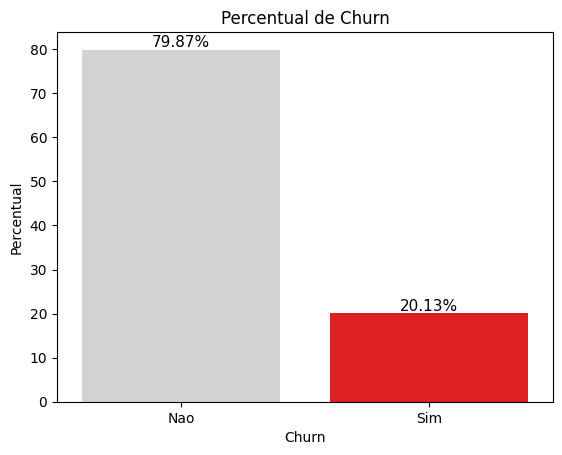

In [14]:
churn_counts = df_churn['Target'].value_counts()

# Calculando percentuais de churn
percent_n = (churn_counts[0] / len(df_churn)) * 100
percent_s = (churn_counts[1] / len(df_churn)) * 100

# Criando dataframe
total_por_churn = pd.DataFrame({'Churn': ['Nao', 'Sim'], 'Percentual': [percent_n, percent_s]})

#Definição de cores
cores = {'Nao': 'lightgrey', 'Sim': 'red'}

# Plot do gráfico
ax = sns.barplot(x='Churn', y='Percentual', hue='Churn', data=total_por_churn, palette=cores, dodge=False)

# Adicionando valores de cada barra
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Churn')
plt.ylabel('Percentual')
plt.title('Percentual de Churn')
plt.show()

<p>Podemos ver que a taxa de churn da base é de 20.13%</p>

## 3.3 Avaliar algumas caracteristicas a partir do IV

In [15]:
def calculate_woe_iv(df, feature, target):
    """
    Calcula WOE (Weight of Evidence) e IV (Information Value) para uma variável.
    """
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    return iv

def iv_table(df, target):
    """
    Retorna uma tabela com IV para todas as variáveis em relação ao target.
    """
    iv_list = []
    for col in df.columns:
        if col == target:
            continue
        iv = calculate_woe_iv(df, col, target)
        if iv < 0.02:
            predictiveness = 'Inútil para a predição'
        elif iv < 0.1:
            predictiveness = 'Preditor Fraco'
        elif iv < 0.3:
            predictiveness = 'Preditor Moderado'
        else:
            predictiveness = 'Preditor Forte'
        iv_list.append({
            'Variável': col,
            'IV': iv,
            'Preditividade': predictiveness
        })

    return pd.DataFrame(iv_list).sort_values(by='IV', ascending=False)

# Exemplo de uso:
iv_df = iv_table(df_churn, 'Target')
iv_df

C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jeanr\anaconda3\envs\global\Lib\site-packages\panda

,Variável,IV,Preditividade
8,Qte_Categorias,0.931941,Preditor Forte
5,Idade,0.909134,Preditor Forte
2,Score_Credito,0.237157,Preditor Moderado
3,Estado,0.166786,Preditor Moderado
10,Programa_Fidelidade,0.151655,Preditor Moderado
4,Gênero,0.072979,Preditor Fraco
7,Limite_Credito_Mercado,0.067084,Preditor Fraco
6,Tempo_Cliente,0.009086,Inútil para a predição
9,Usa_Cartao_Credito,0.000231,Inútil para a predição
0,ClientId,0.000000,Inútil para a predição


<p>Podemos perceber que Qtd_Categorias e Idade tem IV quase igual a 1, que segundo o benchmark é considerado variável forte. </p>
<p>Já Score_Credito e Programa_Fidelidade são variáveis preditoras moderadas.</p>

### Qte_Categorias

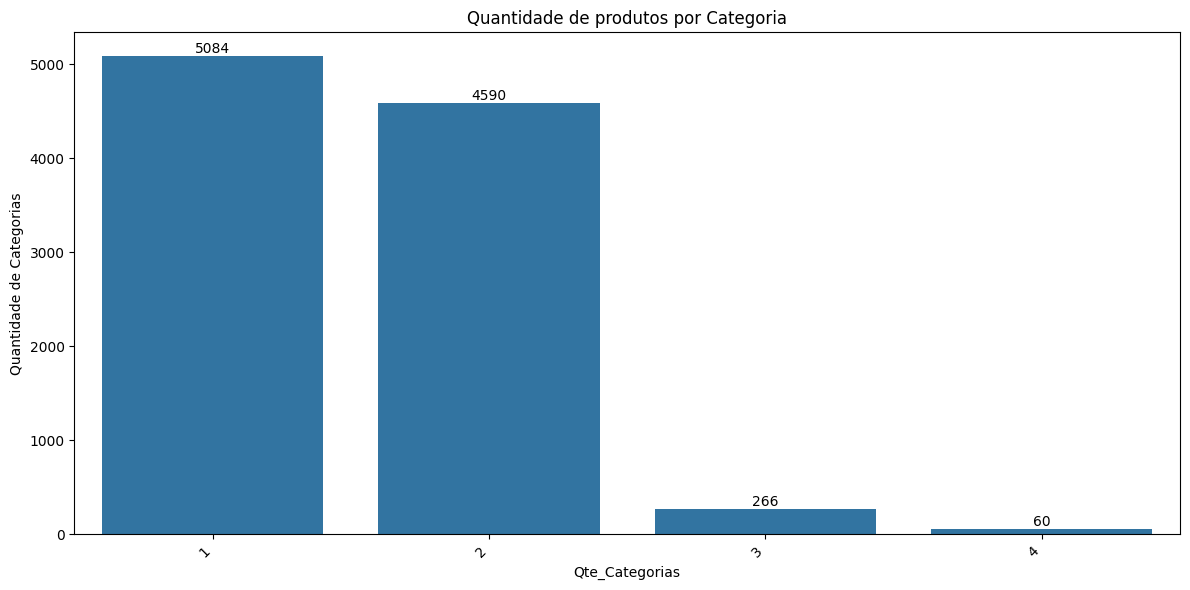

In [16]:
# Contando as ocorrências de cada categoria na variável 'Qte_Categorias' e ordenando em ordem decrescente
categoria_counts = df_churn['Qte_Categorias'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,6))

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='Qte_Categorias', data=df_churn, order=categoria_counts.index)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Qte_Categorias')
plt.ylabel('Quantidade de Categorias')
plt.title('Quantidade de produtos por Categoria')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
plt.show()

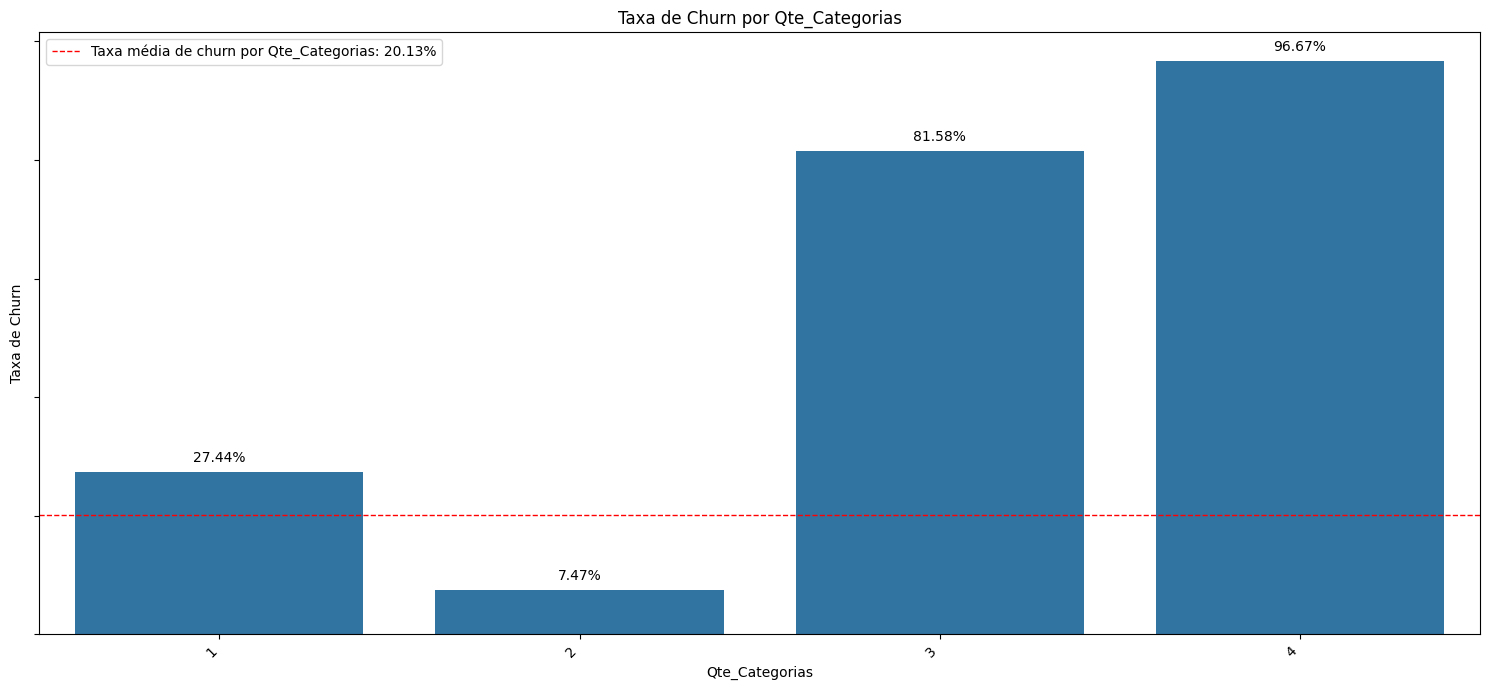

In [17]:

# Calculando a taxa de rotatividade para cada Qte_Categorias
taxa_rotatividade_por_Categoria = df_churn.groupby('Qte_Categorias')['Target'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de rotatividade
funcoes_ordenadas = taxa_rotatividade_por_Categoria.sort_values(ascending=False)

plt.figure(figsize=(15,7))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de rotatividade
taxa_media_rotatividade_categoria = df_churn['Target'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_rotatividade_categoria, color='red', linestyle='dashed', linewidth=1, label='Taxa média de churn por Qte_Categorias: {:.2f}%'.format(taxa_media_rotatividade_categoria * 100))

plt.xlabel('Qte_Categorias')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por Qte_Categorias')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

<p>Percebe-se que pessoas que compram apenas 1 categoria de produtos a taxa média de churn é aproximadamente 7p.p acima da mediana geral. Quem compra em 3 categorias ou 4, a taxa fica bem superior a mediana geral, porém a quantidade absoluta de pessoas comprando também é bem menor. </p>
<p>Pessoas que compram em 2 categorias de produto tem uma taxa de churn 12.66p.p abaixo da mediana geral</p>

### Idade

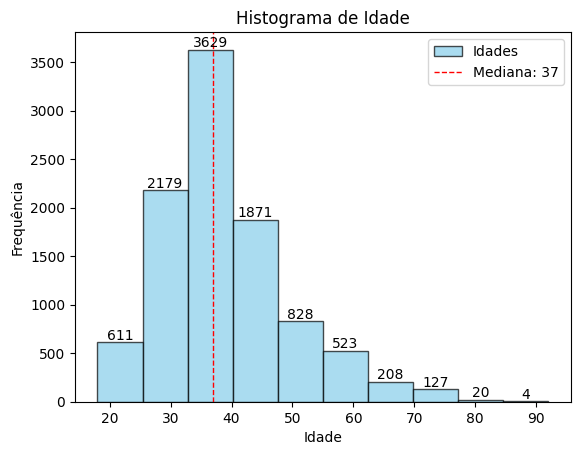

In [18]:
# Plotando o histograma das idades
hist, bins, _ = plt.hist(df_churn['Idade'], bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Idades')

# Calculando a média das idades
mediana_idades = df_churn['Idade'].median()

# Adicionando a linha vertical para a média
plt.axvline(mediana_idades, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Idades', 'Mediana: {:.0f}'.format(mediana_idades)], loc='upper right')

# Adicionando os valores da frequência em cada barra
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Configurando os rótulos e título
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Histograma de Idade')

# Mostrando o gráfico
plt.show()

<p>Percebe-se que 50% do público tem até 37 anos</p>

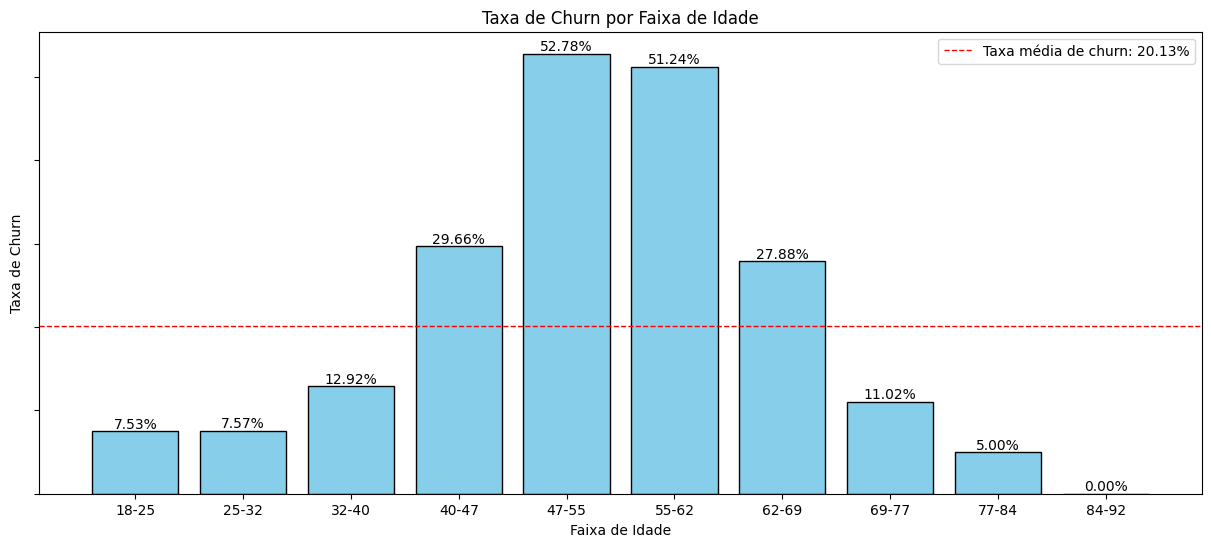

In [19]:
# Calculando o histograma das idades com os mesmos bins do histograma anterior
hist, bins = np.histogram(df_churn['Idade'], bins=10)

# Calculando a taxa de rotatividade para cada faixa de idade
taxa_rotatividade_por_faixa = []
for i in range(len(bins)-1):
    faixa_inferior = bins[i]
    faixa_superior = bins[i+1]
    taxa_rotatividade = df_churn[(df_churn['Idade'] >= faixa_inferior) & (df_churn['Idade'] < faixa_superior)]['Target'].value_counts(normalize=True).get(1, 0)
    taxa_rotatividade_por_faixa.append(taxa_rotatividade)

# Calculando a média da variável de rotatividade
taxa_media_rotatividade = df_churn['Target'].value_counts(normalize=True).get(1, 0)

# Plotando o gráfico de barras
plt.figure(figsize=(15,6))
plt.bar(range(len(bins)-1), taxa_rotatividade_por_faixa, color='skyblue', edgecolor='black')

# Adicionando os valores das taxas de rotatividade nas barras
for i, taxa in enumerate(taxa_rotatividade_por_faixa):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

# Adicionando uma linha indicando a média da variável de rotatividade
plt.axhline(taxa_media_rotatividade, color='red', linestyle='dashed', linewidth=1, label='Taxa média de churn: {:.2f}%'.format(taxa_media_rotatividade * 100))

# Adicionando as faixas de idade no eixo x
plt.xticks(range(len(bins)-1), ['{}-{}'.format(int(faixa_inf), int(faixa_sup)) for faixa_inf, faixa_sup in zip(bins[:-1], bins[1:])])

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando rótulos e título
plt.xlabel('Faixa de Idade')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por Faixa de Idade')

# Adicionando a legenda
plt.legend()

# Mostrando o gráfico
plt.show()

<p>Percebe-se que a taxa média de churn aumenta entre as faixas de idade entre 40 a 69</p>

### Score de Crédito

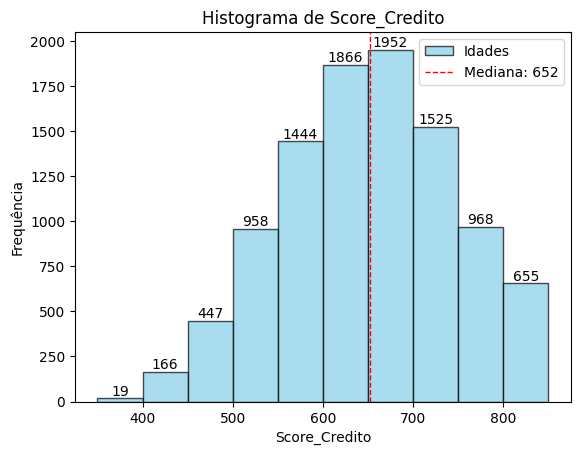

In [20]:
# Plotando o histograma das Score_Credito
hist, bins, _ = plt.hist(df_churn['Score_Credito'], bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Idades')

# Calculando a média das Score_Credito
mediana_score = df_churn['Score_Credito'].median()

# Adicionando a linha vertical para a média
plt.axvline(mediana_score, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Idades', 'Mediana: {:.0f}'.format(mediana_score)], loc='upper right')

# Adicionando os valores da frequência em cada barra
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Configurando os rótulos e título
plt.xlabel('Score_Credito')
plt.ylabel('Frequência')
plt.title('Histograma de Score_Credito')

# Mostrando o gráfico
plt.show()

<p>Percebe-se que 50% do público tem score de até 652.</p>

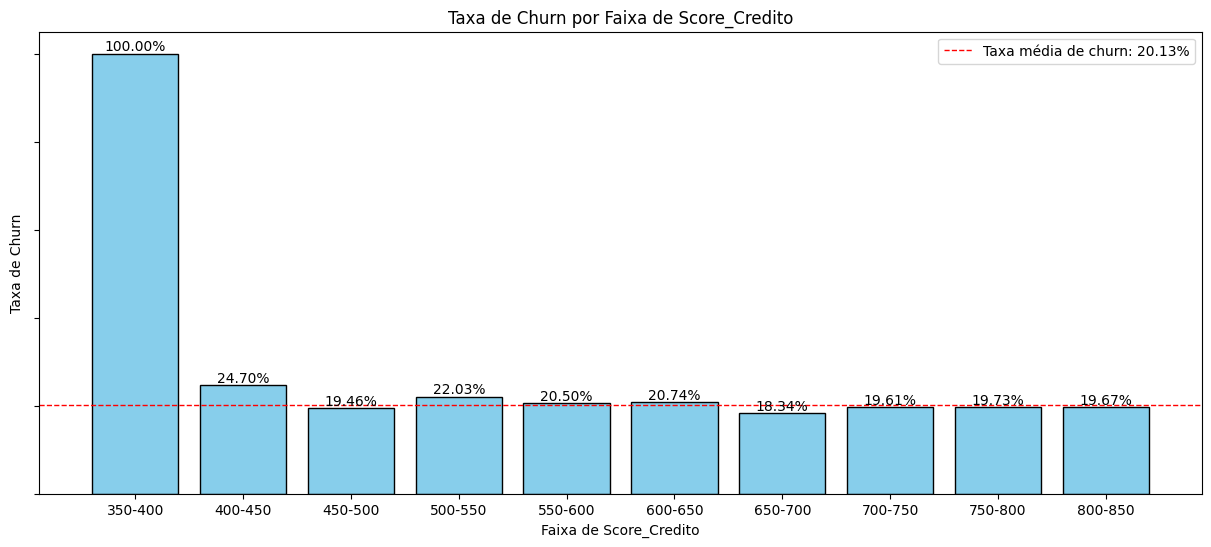

In [21]:
# Calculando o histograma das score com os mesmos bins do histograma anterior
hist, bins = np.histogram(df_churn['Score_Credito'], bins=10)

# Calculando a taxa de rotatividade para cada faixa de Score_Credito
taxa_rotatividade_por_faixa = []
for i in range(len(bins)-1):
    faixa_inferior = bins[i]
    faixa_superior = bins[i+1]
    taxa_rotatividade = df_churn[(df_churn['Score_Credito'] >= faixa_inferior) & (df_churn['Score_Credito'] < faixa_superior)]['Target'].value_counts(normalize=True).get(1, 0)
    taxa_rotatividade_por_faixa.append(taxa_rotatividade)

# Calculando a média da variável de rotatividade
taxa_media_rotatividade = df_churn['Target'].value_counts(normalize=True).get(1, 0)

# Plotando o gráfico de barras
plt.figure(figsize=(15,6))
plt.bar(range(len(bins)-1), taxa_rotatividade_por_faixa, color='skyblue', edgecolor='black')

# Adicionando os valores das taxas de rotatividade nas barras
for i, taxa in enumerate(taxa_rotatividade_por_faixa):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

# Adicionando uma linha indicando a média da variável de rotatividade
plt.axhline(taxa_media_rotatividade, color='red', linestyle='dashed', linewidth=1, label='Taxa média de churn: {:.2f}%'.format(taxa_media_rotatividade * 100))

# Adicionando as faixas de idade no eixo x
plt.xticks(range(len(bins)-1), ['{}-{}'.format(int(faixa_inf), int(faixa_sup)) for faixa_inf, faixa_sup in zip(bins[:-1], bins[1:])])

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando rótulos e título
plt.xlabel('Faixa de Score_Credito')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por Faixa de Score_Credito')

# Adicionando a legenda
plt.legend()

# Mostrando o gráfico
plt.show()

<p>Perceb-se que pessoas com scores de crédito abaixo da médiana geral de 652 possuem uma taxa maior de churn, principalmente aqueles que estão na faixa entre 350 e 400.</p>

### Programa_Fidelidade

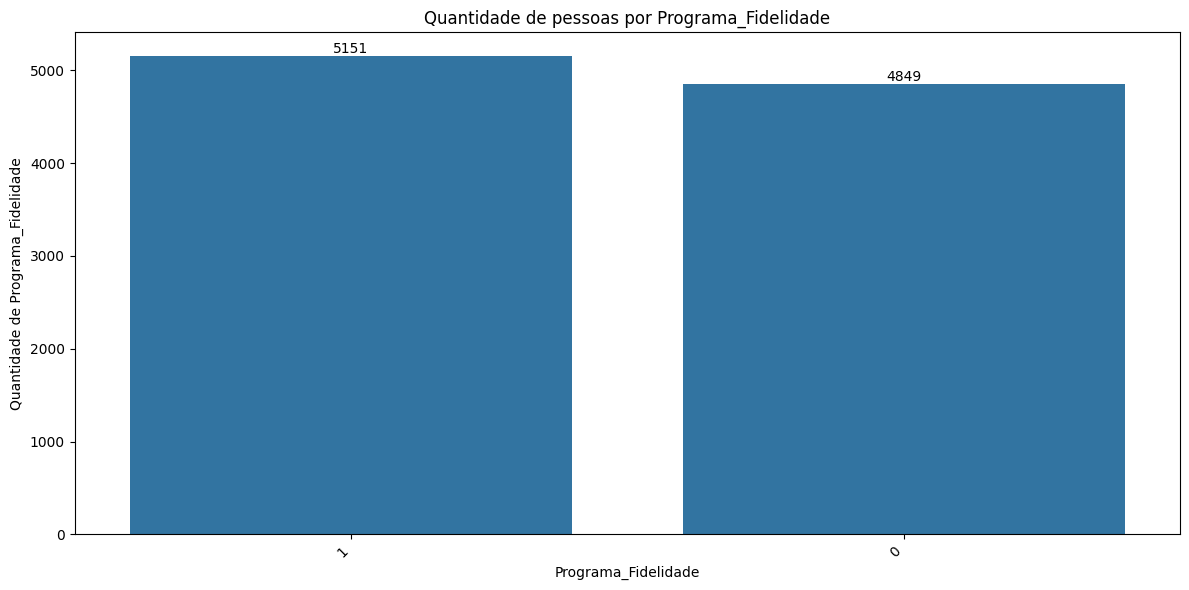

In [22]:
# Contando as ocorrências de cada categoria na variável 'Programa_Fidelidade' e ordenando em ordem decrescente
categoria_counts = df_churn['Programa_Fidelidade'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,6))

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='Programa_Fidelidade', data=df_churn, order=categoria_counts.index)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Programa_Fidelidade')
plt.ylabel('Quantidade de Programa_Fidelidade')
plt.title('Quantidade de pessoas por Programa_Fidelidade')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
plt.show()

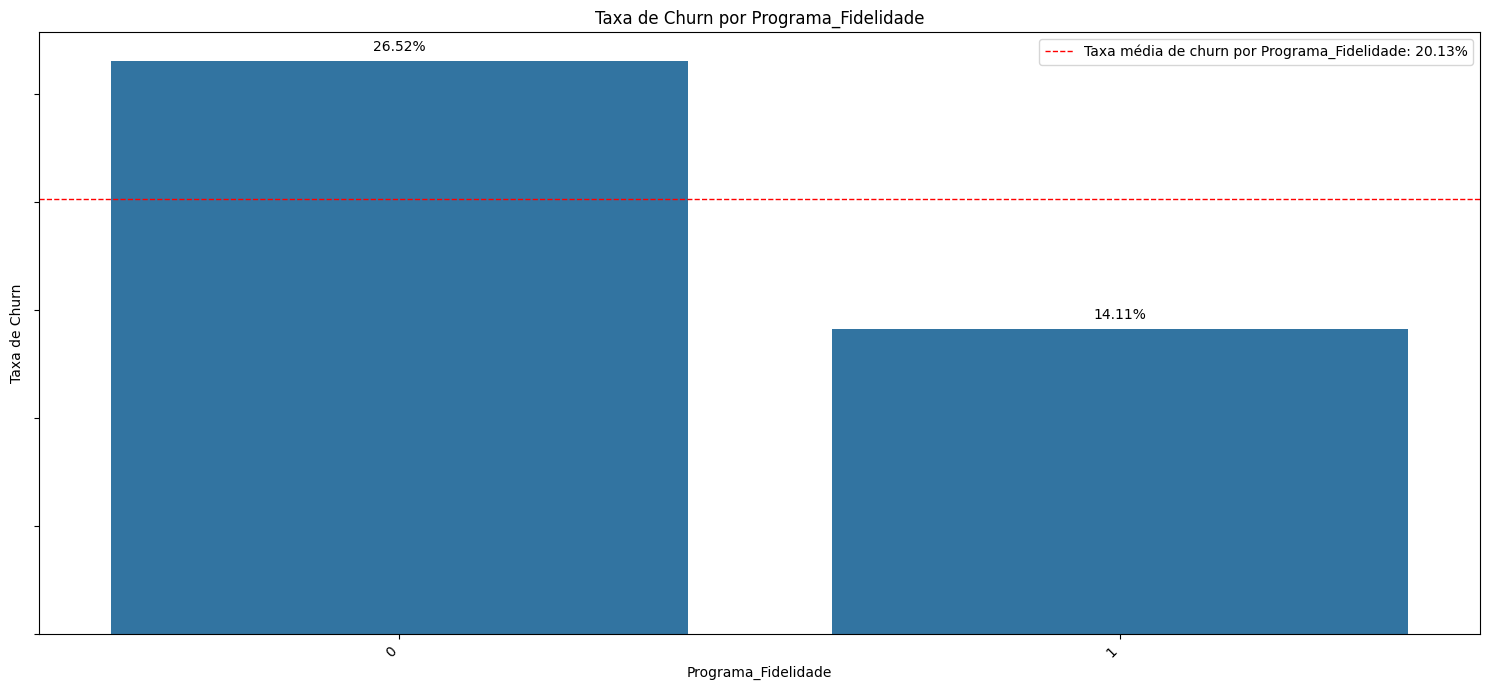

In [23]:

# Calculando a taxa de rotatividade para cada Programa_Fidelidade
taxa_rotatividade_por_Categoria = df_churn.groupby('Programa_Fidelidade')['Target'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de rotatividade
funcoes_ordenadas = taxa_rotatividade_por_Categoria.sort_values(ascending=False)

plt.figure(figsize=(15,7))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de rotatividade
taxa_media_rotatividade_categoria = df_churn['Target'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_rotatividade_categoria, color='red', linestyle='dashed', linewidth=1, label='Taxa média de churn por Programa_Fidelidade: {:.2f}%'.format(taxa_media_rotatividade_categoria * 100))

plt.xlabel('Programa_Fidelidade')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por Programa_Fidelidade')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

<p>Percebe-se que pessoas que possuem programa fidelidade tem uma taxa média 14.11%, sendo 6p.p a menos do que a mediana geral. Já quem náo possui programa fidelidade tem maior taxa de churn, sendo 6,3p.p maior do que a mediana geral</p>